# Guidelines for Google Colab & Google Cloud Storage & Tensorflow CNNs

# Imports

In [1]:
from google.cloud import storage
import os

## Create Bucket

In [13]:
def create_bucket(bucket_name: str):
    """Create a GCS Bucket"""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    bucket.storage_class = "COLDLINE"
    new_bucket = client.create_bucket(bucket, location="eu")
    print(f"New bucket {bucket_name} has been succesfully created!")
    return new_bucket

## Upload File to Bucket From your Local Directory

In [21]:
def upload_file(bucket, filename: str, destination: str):
    """Upload a file to GCS Bucket"""
    blob = bucket.blob(destination)
    blob.upload_from_filename(filename)
    print(f"Uploaded {filename}!")

## Compress! Compress!

We would like to zip our files first before uploading to GCS them & unzip them on our google colab.

We can use the A M A Z I N G Bash to do that:
- !zip -q -r file_name.zip directory_path && echo "success" || echo "failure"
- !unzip -q -d destination file_name.zip && echo "success" || echo "failure"

In [38]:
# !zip -r Chaotic.zip waves/Chaotic
# !unzip -d . Chaotic.zip

In [8]:
!mkdir zipped_waves
!ls

chaos		   mushrooms	  test.ipynb  zipped_waves
cloud_uploader.py  mushrooms.npy  waves


In [9]:
!zip -q -r zipped_waves/Chaotic.zip waves/Chaotic && echo "success" || echo "failure"

success


In [10]:
!zip -q -r zipped_waves/Flat.zip waves/Flat && echo "success" || echo "failure"

success


In [11]:
!zip -q -r zipped_waves/Good.zip waves/Good && echo "success" || echo "failure"

success


Note: You can make a bash script to automate that but let's not complicate ourselves for the moment.

## Time to Upload to GCS

In [14]:
## create bucket
create_bucket("chaotic_waves")

New bucket chaotic_waves has been succesfully created!


<Bucket: chaotic_waves>

### Check my tree structure first

In [42]:
!tree -d

.
├── chaos
│   └── waves
├── mushrooms
│   ├── Agaricus
│   ├── Amanita
│   ├── Boletus
│   ├── Cortinarius
│   ├── Entoloma
│   ├── Hygrocybe
│   ├── Lactarius
│   ├── Russula
│   └── Suillus
├── waves
│   ├── Chaotic
│   ├── Flat
│   ├── Good
│   └── __MACOSX
│       ├── Chaotic
│       ├── Flat
│       └── Good
└── zipped_waves

21 directories


In [22]:
def upload_zipped_files(dir_name : str , bucket_name : str):
    #create a client
    client = storage.Client()

    #fetch bucket we want to store our data on
    bucket = storage.Bucket(client , bucket_name)

    #use our previous function
    for zipped_file in os.listdir(dir_name):
        upload_file(bucket,
                    filename=os.path.join(dir_name, zipped_file),
                    destination=os.path.join(dir_name, zipped_file)
                    )
        print(f"Zipped directory {zipped_file} uploaded!")
    return True

### Example I: Waves

In [23]:
dir_name = "zipped_waves"
bucket_name = "chaotic_waves"

#### Time to Upload

In [24]:
upload_zipped_files(dir_name , bucket_name)

Uploaded zipped_waves/Chaotic.zip!
Zipped directory Chaotic.zip uploaded!
Uploaded zipped_waves/Good.zip!
Zipped directory Good.zip uploaded!
Uploaded zipped_waves/Flat.zip!
Zipped directory Flat.zip uploaded!


True

### Example II: Mushrooms

In [57]:
!ls mushrooms

Agaricus  Boletus      Entoloma   Lactarius  Suillus
Amanita   Cortinarius  Hygrocybe  Russula


In [60]:
## Zip subdirectories:
!mkdir zipped_mushrooms && for f in $(ls mushrooms); do; zip -q -r zipped_mushrooms/$f.zip mushrooms/$f && echo "success" || echo "failure"; done

success
success
success
success
success
success
success
success
success


In [43]:
##create bucket
create_bucket("mushroom_genuses")

New bucket mushroom_genuses has been succesfully created!


<Bucket: mushroom_genuses>

In [61]:
dir_name = "zipped_mushrooms"
bucket_name = "mushroom_genuses"

In [62]:
#upload zipped files to bucket
upload_zipped_files(dir_name, bucket_name)

Uploaded zipped_mushrooms/Boletus.zip!
Zipped directory Boletus.zip uploaded!
Uploaded zipped_mushrooms/Hygrocybe.zip!
Zipped directory Hygrocybe.zip uploaded!
Uploaded zipped_mushrooms/Lactarius.zip!
Zipped directory Lactarius.zip uploaded!
Uploaded zipped_mushrooms/Cortinarius.zip!
Zipped directory Cortinarius.zip uploaded!
Uploaded zipped_mushrooms/Agaricus.zip!
Zipped directory Agaricus.zip uploaded!
Uploaded zipped_mushrooms/Amanita.zip!
Zipped directory Amanita.zip uploaded!
Uploaded zipped_mushrooms/Russula.zip!
Zipped directory Russula.zip uploaded!
Uploaded zipped_mushrooms/Entoloma.zip!
Zipped directory Entoloma.zip uploaded!
Uploaded zipped_mushrooms/Suillus.zip!
Zipped directory Suillus.zip uploaded!


True

#### After it's done check your Google Cloud Storage just to be sure!

## Now let's switch to Google Colab

### First we need to authenticate. That's easy:

In [34]:
#from google.colab import auth
#auth.authenticate_user()

##### Time to unzip from GCS

In [27]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name)

    # Note: The call returns a response only when the iterator is consumed.
    for blob in blobs:
        print(blob.name)

#### Waves Example I

In [28]:
list_blobs("chaotic_waves")

zipped_waves/Chaotic.zip
zipped_waves/Flat.zip
zipped_waves/Good.zip


In [29]:
bucket_name = "chaotic_waves"
parent_blob = "zipped_waves"

#### Mushroom Example II

In [64]:
list_blobs("mushroom_genuses")

zipped_mushrooms/Agaricus.zip
zipped_mushrooms/Amanita.zip
zipped_mushrooms/Boletus.zip
zipped_mushrooms/Cortinarius.zip
zipped_mushrooms/Entoloma.zip
zipped_mushrooms/Hygrocybe.zip
zipped_mushrooms/Lactarius.zip
zipped_mushrooms/Russula.zip
zipped_mushrooms/Suillus.zip


#### We need the "parent_blob" variable as the dictionary which will host all of our zipped files!

#### Remember in GCS the tree structure is merely artificial!

### Download files from GCS

In [35]:
def download_blob(bucket_name, parent_blob: str):
    """Downloads a blob from the bucket."""
    #create client
    storage_client = storage.Client()

    #fetch blob
    blobs = storage_client.list_blobs(bucket_name)

    #make host directory if it doesn't exist
    if not os.path.isdir(parent_blob):
        os.mkdir(parent_blob)

    for blob in blobs:
        #where I want it stored!
        blob.download_to_filename(blob.name)
    return True

#### Unzip them!

In [37]:
import zipfile

def extract_to(parent_blob):
    ##Unzips all files in our parent blob we just downloaded from GCS
    for zipped_file in os.listdir(parent_blob):
        print(f"Unzipping {zipped_file}...")
        with zipfile.ZipFile(os.path.join(parent_blob, zipped_file),
                             'r') as zip_ref:
            #we do not define an extraction directory since the zipped files already contain
            #the directories, since there was a large folder containing
            #all subsequent folders with files belonging to each category
            zip_ref.extractall()
        print("Success!")

#### Example I: Waves

In [68]:
bucket_name = "chaotic_waves"
parent_blob = "zipped_waves"

In [69]:
#download_blob(bucket_name, parent_blob)

In [ ]:
#extract_to(parent_blob)

#### Example II: Mushrooms

In [70]:
parent_blob = "zipped_mushrooms"
bucket_name = "mushroom_genuses"

In [71]:
#download_blob(bucket_name, parent_blob)

In [72]:
#extract_to(parent_blob)

## CNN Architecture

#### Model Building for Tensorflow

In [74]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import efficientnet

2022-11-29 00:13:56.876777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### We need a train and validation test split

In [67]:
image_size = 400
batch_size = 40

In [80]:
##file count of total mushrooms pictures
count = sum(len(files) for root, dirs, files in os.walk('mushrooms'))
count

6714

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # set validation split

In [77]:
train_data_dir = "mushrooms"
image_height , image_width = 400 , 400

In [81]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical', #switch to 'binary' if your task is binary!
    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,  # same directory as training data
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical', #switch to 'binary' if your task is binary!
    subset='validation')  # set as validation data

Found 5375 images belonging to 9 classes.
Found 1339 images belonging to 9 classes.


In [21]:
train_generator.class_indices

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Hygrocybe': 5,
 'Lactarius': 6,
 'Russula': 7,
 'Suillus': 8}

In [92]:
#solves problem with truncated images
# 
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
from keras import models , layers
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Transfer Learning 

In [23]:
def initialize_model():
    n_classes = 9
    model = models.Sequential()
    model.add(
        efficientnet.EfficientNetB7(weights = 'imagenet',
                                     include_top = False,
                                     classes = n_classes,
                                     input_shape = (400,400,3))
    )
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(100, activation = "relu"))
    #if more computational power is available! 
    #make it more complex!
    
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dense(1024, activation = "relu"))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dense(256, activation = "relu"))
    # model.add(layers.BatchNormalization())

    model.add(layers.Dense(9, activation = "softmax"))
    model.layers[0].trainable = False
    return model


model = initialize_model()

258076736/258076736 [==============================] - 25s 0us/step


In [83]:
def compile_model(model , learning_rate : float):
    model.compile(loss = "categorical_crossentropy",
                  metrics = "accuracy" ,
                  optimizer = Adam(learning_rate = learning_rate)
                  )
    return model

In [88]:
def train_model(train_generator , 
                validation_generator ,
                 image_counts : int , 
                 epochs : int , 
                 patience : int , 
                 batch_size : int , 
                 verbose : bool = True):
    es = EarlyStopping(patience = patience,  restore_best_weights= True)
    history = model.fit(train_generator,
                steps_per_epoch = int(image_counts/batch_size) + 1,
                epochs = epochs,
                callbacks = [es],
                validation_data = validation_generator ,
                verbose = verbose
                )
    return model , history

## Manual Preprocessing Guidelines

In [89]:
X = []
y = []

idx = 0
for genus in os.listdir("mushrooms"):
    for image in os.listdir(f"mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("mushrooms", genus , image) )
        trans_img = cv2.resize( temp_img , (400,400) , interpolation = cv2.INTER_AREA)
        X.append(trans_img)
        y.append(genus)
        idx += 1
        break

X_ = np.concatenate(X , axis = 0).reshape((idx, 400,400,3))
y_ = np.array(y)
X_.shape , y_.shape

((9, 400, 400, 3), (9,))

(<matplotlib.image.AxesImage at 0x7fe286377b20>, 'Cortinarius')

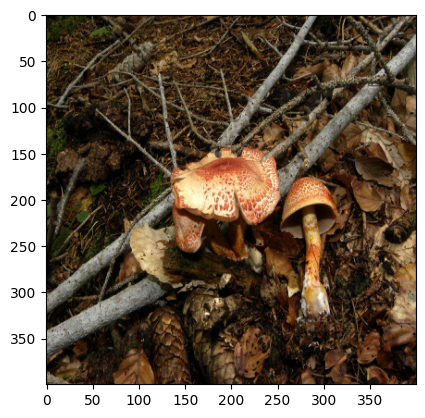

In [90]:
plt.imshow(X_[0]) , y_[0]

In [22]:
np.save("mushrooms",X_)

In [23]:
!ls

cloud_uploader.py  mushrooms  mushrooms.npy  test.ipynb


In [24]:
X_train = np.load("mushrooms.npy")

In [25]:
X_train.shape

(9, 400, 400, 3)

In [91]:
from sklearn.model_selection import train_test_split